In [2]:
"""
High-level fitting and plotting example with MulensModel.

Requires in-line argument which is a config file, e.g.,
example_15_mb07192_v1.cfg or example_15_ob05390_v1.cfg.
"""
!pip install emcee
!pip install MulensModel

from datetime import datetime
start_time = datetime.now() # initialize timer
import sys
import numpy as np
import emcee
from matplotlib import pyplot as plt
import configparser
import scipy.optimize as op
import os
import astropy.units as u

import MulensModel as mm

import example_15_read as read

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 11.2 MB/s eta 0:00:00


In [4]:
def bounded_gaussian_sampler(mean, std_dev, min_val, max_val, size=1):
    """
    Generates a specified number of samples from a Gaussian distribution,
    ensuring all values are within a defined range.

    Args:
        mean (float): The mean of the Gaussian distribution.
        std_dev (float): The standard deviation of the Gaussian distribution.
        min_val (float): The minimum acceptable value.
        max_val (float): The maximum acceptable value.
        size (int): The number of samples to generate.

    Returns:
        numpy.ndarray: An array of samples within the specified bounds.
    """
    samples = []
    while len(samples) < size:
        # Generate a random number from the Gaussian distribution
        new_sample = np.random.normal(loc=mean, scale=std_dev)

        # Check if the number is within the bounds
        if min_val <= new_sample <= max_val:
            samples.append(new_sample)

    return np.array(samples)

def ln_like(theta, event, parameters_to_fit, print_models):
    """
    Likelihood function. The values of *parameters_to_fit* are in *theta*.
    MulensModel Event class instance *event* gives event for which
    calculations will be done. Boolean *print_models* controls if
    all models are printed.
    """
    for (theta_, param) in zip(theta, parameters_to_fit):
        setattr(event.model.parameters, param, theta_)
    chi2 = event.get_chi2()
    if print_models:
        print(chi2, *[t for t in theta], flush=True)
    return -0.5 * chi2


def ln_prior(theta, parameters_to_fit):
    """
    Prior. Check if *theta* values for *parameters_to_fit* are within ranges
    defined by *ln_prior.min* and *ln_prior.max*.
    """
    inside = 0.
    outside = -np.inf

    for (parameter, value) in ln_prior.min.items():
        index = parameters_to_fit.index(parameter)
        if theta[index] < value:
            return outside

    for (parameter, value) in ln_prior.max.items():
        index = parameters_to_fit.index(parameter)
        if theta[index] > value:
            return outside

    return inside


def ln_prob(
        theta, event, parameters_to_fit, print_models=False):
    """
    Log probability of the model - combines ln_prior() and ln_like().
    """
    ln_prior_ = ln_prior(theta, parameters_to_fit)
    if not np.isfinite(ln_prior_):
        return -np.inf

    ln_like_ = ln_like(theta, event, parameters_to_fit, print_models)
    if np.isnan(ln_like_):
        return -np.inf

    return ln_prior_ + ln_like_


def generate_random_parameters(parameters, starting, n, n_sigma):
    """
    Generate *n* vectors of values of *parameters* according to distributions
    specified in *starting*, regenerating values outside of bounds for Gaussian priors.
    """
    values = []
    for param in parameters:
        settings = starting[param]
        print(param)
        if settings[0] == 'gauss':
            mean = settings[1]
            std = settings[2]
            size = n
            print((mean - std*n_sigma), (mean + std*n_sigma))
            if (param != 'rho') and (param != 'alpha'):
                v = bounded_gaussian_sampler(mean, std, (mean - std*n_sigma), (mean + std*n_sigma), size=size)
            elif param == 'alpha':
                v = bounded_gaussian_sampler(mean, std, 0., 360., size=size)
            elif param == 'rho':
                v = bounded_gaussian_sampler(mean, std, 0., 0.1, size=size)
            else:
                raise ValueError('Unrecognized keyword: ' + settings[0])

        elif settings[0] == 'uniform':
            v = np.random.uniform(
                low=settings[1], high=settings[2], size=n)
        elif settings[0] == 'log-uniform':
            beg = np.log(settings[1])
            end = np.log(settings[2])
            v = np.exp(np.random.uniform(beg, end, n))
        else:
            raise ValueError('Unrecognized keyword: ' + settings[0])

        values.append(v)
    return np.array(values).T.tolist()

# Define fitting functions

def chi2_fun(theta, event, parameters_to_fit):
    """
    Chi2 function. Changes values of the parameters and recalculates chi2.

    event = a MulensModel.Event
    parameters_to_fit = list of names of parameters to be changed
    theta = values of the corresponding parameters
    """
    # key = the name of the MulensModel parameter
    for (index, key) in enumerate(parameters_to_fit):
        if (key == 't_E' or key =='rho') and theta[index] < 0.:
            return np.inf
        setattr(event.model.parameters, key, theta[index])
    return event.get_chi2()

def fit_model(event, parameters_to_fit):
    """
    Fit an "event" with "parameters_to_fit" as free parameters.

    event = a MulensModel event
    parameters_to_fit = list of parameters to fit
    """
    # Take the initial starting point from the event.
    x0 = []
    for key in parameters_to_fit:
        value = getattr(event.model.parameters, key)
        if isinstance(value, u.Quantity):
            x0.append(value.value)
        else:
            x0.append(value)

    # *Execute fit using a 'Nelder-Mead' algorithm*
    result = op.minimize(
        chi2_fun, x0=x0, args=(event, parameters_to_fit),
        method='Nelder-Mead')

    return result

def make_grid_model(index):
    """
    Define a Model using the gridpoint information + the PSPL parameters.

    index = index of the grid point for which to generate the model
    """
    model = mm.Model({
        't_0': point_lens_event.model.parameters.t_0,
        'u_0': point_lens_event.model.parameters.u_0,
        't_E': point_lens_event.model.parameters.t_E,
        'rho': grid[4, index],
        's': 10.**grid[0, index],
        'q': 10.**grid[1, index],
        'alpha': grid[3, index]})
    model.set_magnification_methods(magnification_methods)
    return model

In [8]:
# ***Read in data file***
# Define the file name and the Julian date offset
filename = 'kmtnet_high_mag.dat'
offset = 2450000.0

# 1. Read the data from the original file into separate NumPy arrays
time, flux, uncertainty = np.loadtxt(filename, unpack=True)

# 2. Convert the time data by adding the offset
full_julian_time = time + offset

# 3. Combine the converted time with the original flux and uncertainty
# and save it to a new file.
new_data = np.column_stack([full_julian_time, flux, uncertainty])
np.savetxt('kmtnet_high_mag_full_jd.dat', new_data, fmt='%.4f')

# 4. Create a new MulensData object by loading the newly created file.
# This ensures the object is initialized correctly.
data = mm.MulensData(file_name='kmtnet_high_mag_full_jd.dat')

print(f"First 5 time points from the new MulensData object: {data.time[:5]}")

First 5 time points from the new MulensData object: [2456040.0884 2456040.1032 2456040.2204 2456040.3658 2456040.3853]


Best-fit Point Lens (using all data)
    t_0 (HJD)       u_0    t_E (d) 
2456141.18091  0.072980    90.1339 
default magnification method: point_source
Chi2 of the point lens model (using all data): 7305.183608299102
detectable, run mcmc


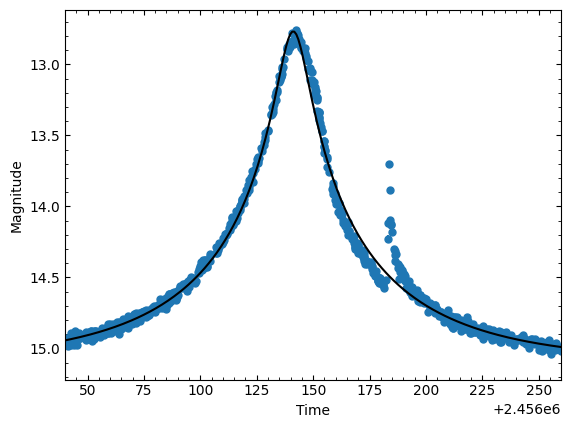

[ 2.08621450e-02  1.71015546e-03  7.59094305e-03  3.86483075e-03
 -1.74714901e-02  2.02509517e-02 -2.46754113e-04  4.36565793e-02
  3.42474315e-03  3.61102225e-02  1.54256309e-02  2.16183870e-03
  1.88608010e-02 -4.95499579e-03 -4.53089899e-02  1.60014308e-02
  4.04575477e-02  8.21368241e-03  8.92597280e-03 -3.72660613e-03
  3.22264464e-02  4.33254880e-02  2.71835815e-03 -2.61248926e-03
 -4.79230877e-02 -6.67155481e-03  1.12891814e-03  1.56111259e-03
 -1.05548212e-02  9.07958340e-03  4.92491155e-02 -3.41168072e-02
  5.34318741e-03  6.22595703e-03 -3.79034490e-03 -2.07750022e-03
  3.04817292e-02 -2.79374508e-02  5.97985277e-03  1.60807175e-03
 -1.70303548e-02  5.52332097e-03  1.37726502e-02 -2.28381125e-02
 -2.30462467e-02  5.09609716e-02 -1.81354452e-02  4.13544454e-02
 -1.74385570e-02 -4.11825480e-03  1.93436783e-02 -1.48333330e-02
  8.80141610e-03 -6.95311783e-04 -6.16166659e-03  3.45622412e-02
 -7.85879872e-03 -2.07743290e-02  3.40388086e-02 -6.02426260e-03
 -1.59185385e-02  2.56370

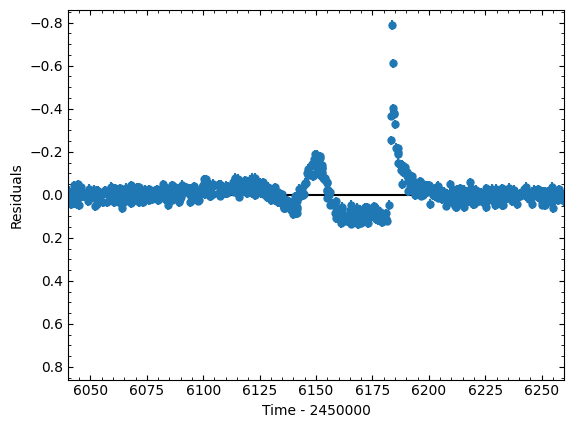

In [9]:
# ***Estimate point lens parameters assuming zero blending, using ALL data***
#

# Create a new MulensData object using all data (no bad points initially)
data_all = mm.MulensData(file_name='kmtnet_high_mag_full_jd.dat')

# Estimate t_0 (time of peak magnification) using all data
index_t_0_all = np.argmin(data_all.mag)
t_0_all = data_all.time[index_t_0_all]

# Estimate u_0 using all data
baseline_mag_all = np.min([data_all.mag[0], data_all.mag[-1]]) # A crude estimate
A_max_all = 10.**((data_all.mag[index_t_0_all] - baseline_mag_all) / -2.5)
u_0_all = 1. / A_max_all # True in the high-magnification limit

# Estimate t_E by determining when the light curve is A(t) = 1.3 (i.e. delta_mag = 0.3) using all data
t_1_all = np.interp(
    baseline_mag_all - 0.3, data_all.mag[index_t_0_all:0:-1], data_all.time[index_t_0_all:0:-1])
t_E_all = np.abs((t_0_all - t_1_all) / np.sqrt(1. - u_0_all**2))

# Define the Point Lens Model using all data
point_lens_model_all = mm.Model({'t_0': t_0_all, 'u_0': u_0_all, 't_E': t_E_all})
point_lens_event_all = mm.Event(datasets=data_all, model=point_lens_model_all)

# Fit the Point Lens Model using all data
result_all = fit_model(point_lens_event_all, parameters_to_fit=['t_0', 'u_0', 't_E'])
print('Best-fit Point Lens (using all data)')
print(point_lens_event_all.model)
chi2_all_data = point_lens_event_all.get_chi2()
print(f"Chi2 of the point lens model (using all data): {chi2_all_data}")

# Check if chi2 / no. of data points < 1.2
chi2_per_datapoint = chi2_all_data / len(data_all.time)

if chi2_per_datapoint < 1.2:
    print("undetectable, no need to run mcmc")
else:
    print("detectable, run mcmc")


# Plot
point_lens_event_all.plot_model(
    t_range=[point_lens_event_all.model.parameters.t_0 - 5. * point_lens_event_all.model.parameters.t_E,
             point_lens_event_all.model.parameters.t_0 + 5. * point_lens_event_all.model.parameters.t_E],
    color='black', zorder=10)
point_lens_event_all.plot_data()
plt.show()

point_lens_event_all.plot_residuals(
            show_errorbars=None, data_ref=data_all, subtract_2450000=True)
lines = plt.gca().get_lines()  # Gets all line objects on the current axes
line = lines[0]  # For the first plotted line, for example

ydata = line.get_ydata()  # Get the y values of that line
print(ydata)


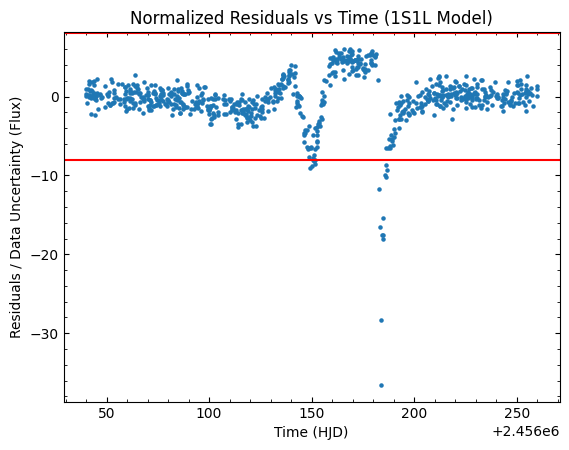

Time of largest deviation: 2456183.6971
Normalized residual at largest deviation: -36.5300
Time to the left where residual crosses zero/changes sign: 2456182.3954
Time to the right where residual crosses zero/changes sign: 2456193.7648


In [13]:


data_uncertainties_all = data_all.err_mag # Assuming err_mag stores flux uncertainties



# Calculate normalized residuals in flux space
# Normalization is by the data uncertainty in flux
normalized_residuals_flux = ydata / data_uncertainties_all


# Plot the normalized residuals against time
plt.figure()
plt.scatter(data_all.time, normalized_residuals_flux, s=5)
plt.xlabel('Time (HJD)')
plt.ylabel('Residuals / Data Uncertainty (Flux)')
plt.title('Normalized Residuals vs Time (1S1L Model)')
plt.axhline(y=8, color='r', linestyle='-')
plt.axhline(y=-8, color='r', linestyle='-')
plt.show()

# Find the index of the point with the largest absolute normalized residual
max_deviation_index = np.argmax(np.abs(normalized_residuals_flux))
max_deviation_time = data_all.time[max_deviation_index]
max_deviation_residual = normalized_residuals_flux[max_deviation_index]

# Find the time to the left where the residual crosses zero or changes sign
time_left = None
for i in range(max_deviation_index - 1, -1, -1):
    if normalized_residuals_flux[i] * max_deviation_residual <= 0:
        time_left = data_all.time[i]
        break

# Find the time to the right where the residual crosses zero or changes sign
time_right = None
for i in range(max_deviation_index + 1, len(normalized_residuals_flux)):
    if normalized_residuals_flux[i] * max_deviation_residual <= 0:
        time_right = data_all.time[i]
        break

print(f"Time of largest deviation: {max_deviation_time:.4f}")
print(f"Normalized residual at largest deviation: {max_deviation_residual:.4f}")
print(f"Time to the left where residual crosses zero/changes sign: {time_left:.4f}" if time_left is not None else "Could not find time to the left")
print(f"Time to the right where residual crosses zero/changes sign: {time_right:.4f}" if time_right is not None else "Could not find time to the right")

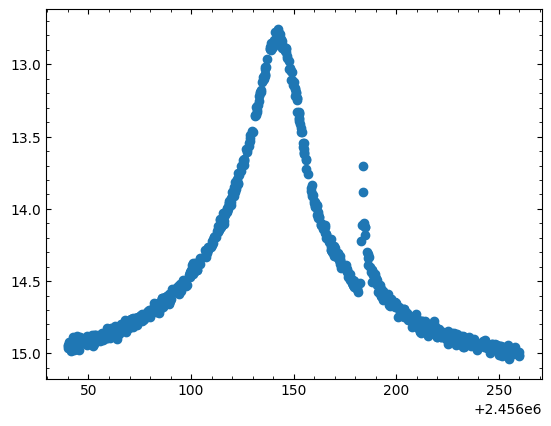

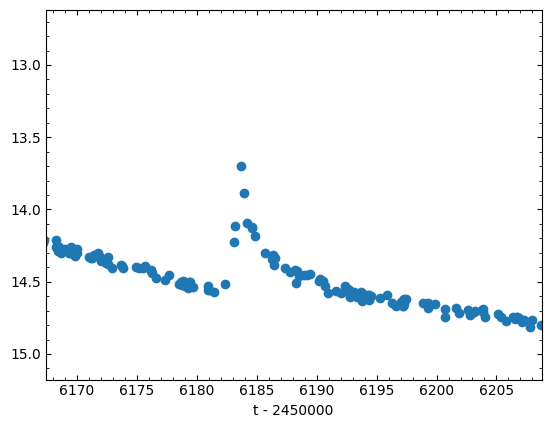

In [14]:
# Plot the data
plt.errorbar(data.time, data.mag, yerr=data.err_mag, fmt='o')
plt.gca().invert_yaxis()
plt.show()
peak_size = 15
# ***Define plot limits for a zoom (of the planetary perturbation)***
(t_min, t_max) = (time_left - peak_size, time_right + peak_size)

# Plot a zoom of the data
plt.errorbar(data.time - 2450000., data.mag, yerr=data.err_mag, fmt='o')
plt.xlim(t_min - 2450000., t_max - 2450000.)
plt.xlabel('t - 2450000')
plt.gca().invert_yaxis()
plt.show()

Best-fit Point Lens
    t_0 (HJD)       u_0    t_E (d) 
2456141.09523  0.094305    72.3550 
default magnification method: point_source


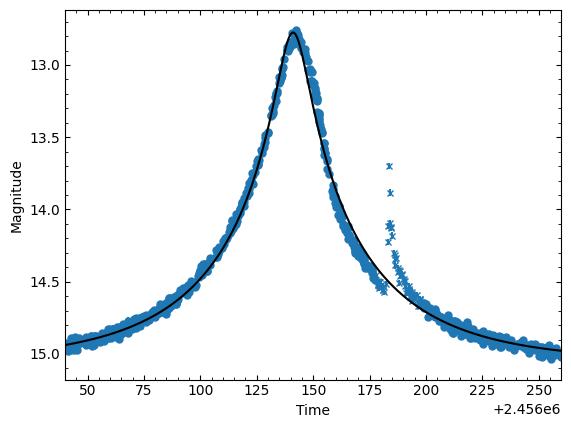

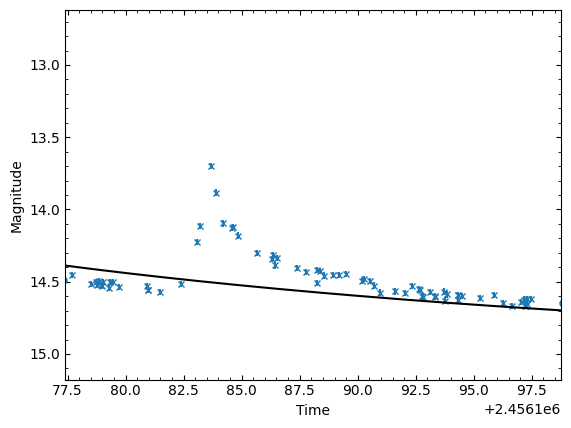

In [62]:
# ***Set time range of planetary perturbation (including 2460000).***
(t_planet_start, t_planet_stop) = (t_min, t_max)

# *Set the magnification methods for the planet model*
# VBBL method will be used between t_planet_start and t_planet_stop,
# and point_source_point_lens will be used everywhere else.
magnification_methods = [
    0., 'point_source_point_lens',
    t_planet_start, 'VBBL', t_planet_stop,
    'point_source_point_lens', 2470000.]

# Flag data related to the planet
flag_planet = (data.time > t_planet_start) & (data.time < t_planet_stop) | np.isnan(data.err_mag)

# Exclude those data from the fitting (for now)
data.bad = flag_planet

# Estimate point lens parameters assuming zero blending
#
# Equation for point lens magnification:
#
# A(u) = (u^2 + 2) / (u * sqrt(u^2 + 4))
#
# where
#
# u = sqrt(u_0^2 + tau^2) and tau = (t - t_0) / t_E
#
# Thus, the light curve is defined by 3 variables: t_0, u_0, t_E
#

# Estimate t_0 (time of peak magnification)
index_t_0 = np.argmin(data.mag[np.invert(flag_planet)])
t_0 = data.time[index_t_0]

# Estimate u_0
baseline_mag = np.min([data.mag[0], data.mag[-1]]) # A crude estimate
A_max = 10.**((data.mag[index_t_0] - baseline_mag) / -2.5)
u_0 = 1. / A_max # True in the high-magnification limit

# Estimate t_E by determining when the light curve is A(t) = 1.3 (i.e. delta_mag = 0.3)
t_1 = np.interp(
    baseline_mag - 0.3, data.mag[index_t_0:0:-1], data.time[index_t_0:0:-1])
t_E = np.abs((t_0 - t_1) / np.sqrt(1. - u_0**2))

# Define the Point Lens Model
point_lens_model = mm.Model({'t_0': t_0, 'u_0': u_0, 't_E': t_E})
point_lens_event = mm.Event(datasets=data, model=point_lens_model)


# Fit the Point Lens Model
result = fit_model(point_lens_event, parameters_to_fit=['t_0', 'u_0', 't_E'])
print('Best-fit Point Lens')
print(point_lens_event.model)

# Plot
point_lens_event.plot_model(
    t_range=[point_lens_event.model.parameters.t_0 - 5. * point_lens_event.model.parameters.t_E,
             point_lens_event.model.parameters.t_0 + 5. * point_lens_event.model.parameters.t_E],
    color='black', zorder=10)
point_lens_event.plot_data(show_bad=True)
plt.show()

point_lens_event.plot_model(color='black', zorder=10)
point_lens_event.plot_data(show_bad=True)
plt.xlim(t_min, t_max)
plt.show()

    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
2456141.09523  0.094305    72.3550 0.00100   1.38054   0.00010000   171.73696 
default magnification method: point_source
other magnification methods: [0.0, 'point_source_point_lens', np.float64(2456177.3954), 'VBBL', np.float64(2456198.7648), 'point_source_point_lens', 2470000.0]


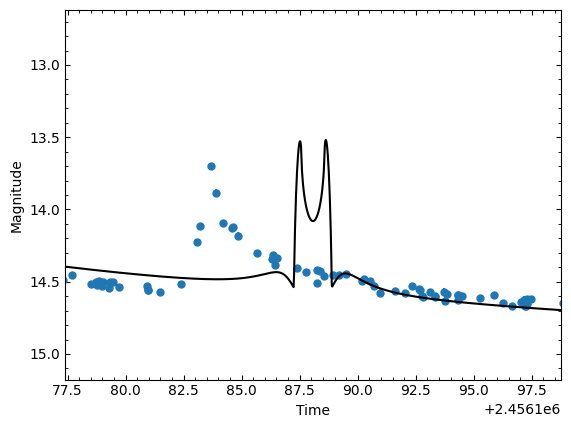

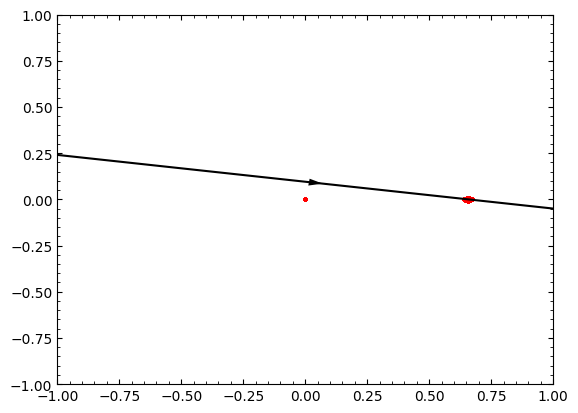

In [63]:
# Un-flag planet data (include it in future fits)
data.bad = np.isnan(data.err_mag)

# Estimate s (projected separation) of the planet, alpha (angle of source trajectory)

# Approximate time of the planetary perturbation
t_planet = (t_planet_stop + t_planet_start) / 2.

# Position of the source at the time of the planetary perturbation
tau_planet = ((t_planet - point_lens_event.model.parameters.t_0) /
              point_lens_event.model.parameters.t_E)
u_planet = np.sqrt(
    point_lens_event.model.parameters.u_0**2 + tau_planet**2)

# Position of the lens images at the time of the planetary perturbation
# --> Estimate of the planet location
s_minus = 0.5 * (np.sqrt(u_planet**2 + 4.) - u_planet)
s_plus = 0.5 * (np.sqrt(u_planet**2 + 4.) + u_planet)

# Angle between the source trajectory and the binary axis
alpha_planet = np.rad2deg(-np.arctan2(
    point_lens_event.model.parameters.u_0, tau_planet)) + 180.

# Check the estimated model
# Note that there are two possibilities for s: s_plus and s_minus.
# Only s_plus is tested here, but both are considered in the grid search below.

# Define the model
test_model = mm.Model({
    't_0': point_lens_event.model.parameters.t_0,
    'u_0': point_lens_event.model.parameters.u_0,
    't_E': point_lens_event.model.parameters.t_E,
    'rho': 0.001,
    's': s_plus,
    'q': 10.**(-4),
    'alpha': alpha_planet})
test_model.set_magnification_methods(magnification_methods)
test_event = mm.Event(datasets=data, model=test_model)
print(test_event.model)

# Plot the model light curve
test_event.plot_data()
test_event.plot_model(t_range=[t_min, t_max], color='black', zorder=10)
plt.xlim(t_min, t_max)
plt.show()
plt.savefig('initial_fit.pdf')

# Plot the trajectory of the source relative to the caustics
test_event.model.plot_trajectory(color='black', caustics=True)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.savefig('trajectory.pdf')
# It doesn't have to be perfect, but there should be a planetary perturbation
# at around the time of the perturbation in the data. If there is no perturbation
# and/or the source trajectory doesn't pass very near/through the caustics, there is some
# problem with the model and the fit will likely fail.

In [64]:
# Using the Point Lens fit as input, search for a planetary solution
#
# Grid parameters: s (log), q (log)
# Fit parameters: rho, alpha
# PSPL parameters: t_0, u_0, t_E
#

# *Define the grid*
delta_log_s = 0.005
delta_log_q = 0.05
print(s_plus, s_minus)
grid_log_s = np.hstack(
    (np.arange(
        np.log10(s_minus) - 0.02, np.log10(s_minus) + 0.02, delta_log_s),
    np.arange(
        np.log10(s_plus) - 0.02, np.log10(s_plus) + 0.02, delta_log_s)))
grid_log_q = np.arange(-5, -2, delta_log_q)

# For each grid point, fit for rho, alpha
grid = np.empty((5, len(grid_log_s) * len(grid_log_q)))
i = 0
print('{0:>12} {1:>6} {2:>7} {3:>7} {4:>7}'.format('chi2', 's', 'q', 'alpha', 'rho'))
for log_s in grid_log_s:
    for log_q in grid_log_q:
        # The major and minor images are on opposite sides of the lens:
        if log_s < 0.:
            alpha = alpha_planet + 180.
        else:
            alpha = alpha_planet

        # Define the Model and Event
        planet_model = mm.Model({
            't_0': point_lens_event.model.parameters.t_0,
            'u_0': point_lens_event.model.parameters.u_0,
            't_E': point_lens_event.model.parameters.t_E,
            'rho': 0.001,
            's': 10.**log_s,
            'q': 10.**log_q,
            'alpha': alpha})
        planet_model.set_magnification_methods(magnification_methods)
        planet_event = mm.Event(datasets=[data], model=planet_model)

        # Fit the Event
        result = fit_model(planet_event, parameters_to_fit=['rho', 'alpha'])
        if result.success:
            chi2 = planet_event.get_chi2()
        else:
            chi2 = np.inf

        # Print and store result of fit
        print('{0:12.2f} {1:6.4f} {2:7.5f} {3:7.2f} {4:7.5f}'.format(
            chi2, 10.**log_s, 10.**log_q,
            planet_event.model.parameters.alpha, planet_event.model.parameters.rho))
        grid[0, i] = log_s
        grid[1, i] = log_q
        grid[2, i] = chi2
        grid[3, i] = planet_event.model.parameters.alpha
        grid[4, i] = planet_event.model.parameters.rho

        i += 1

1.3805350568295771 0.7243568318333891
        chi2      s       q   alpha     rho
     7368.49 0.6918 0.00001  354.00 0.00104
     7366.42 0.6918 0.00001  354.01 0.00104
     7364.13 0.6918 0.00001  354.03 0.00104
     7361.60 0.6918 0.00001  354.05 0.00104
     7358.82 0.6918 0.00002  354.07 0.00104
     7355.78 0.6918 0.00002  354.10 0.00104
     7352.46 0.6918 0.00002  354.13 0.00104
     7348.86 0.6918 0.00002  354.16 0.00103
     7344.98 0.6918 0.00003  354.21 0.00103
     7340.81 0.6918 0.00003  354.25 0.00103
     7336.34 0.6918 0.00003  354.31 0.00103
     7331.58 0.6918 0.00004  354.37 0.00102
     7326.53 0.6918 0.00004  354.43 0.00102
     7321.18 0.6918 0.00004  354.51 0.00102
     7315.54 0.6918 0.00005  354.59 0.00116
     7309.58 0.6918 0.00006  354.67 0.00102
     7303.31 0.6918 0.00006  354.77 0.00102
     7296.71 0.6918 0.00007  354.87 0.00103
     7289.76 0.6918 0.00008  354.98 0.00098
     7282.44 0.6918 0.00009  355.10 0.00099
     7274.73 0.6918 0.00010  355.22 0.

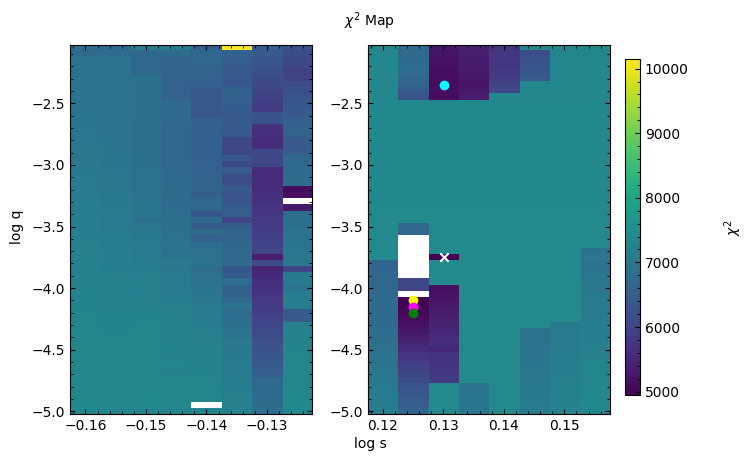

<Figure size 640x480 with 0 Axes>

In [65]:
# Plot the grid

# Identify the best model(s)
index_best = np.argmin(np.array(grid[2,:]))
index_sorted = np.argsort(np.array(grid[2,:]))
n_best = 5
colors = ['magenta', 'green', 'cyan','yellow']
if len(colors) < n_best - 1:
    raise ValueError('colors must have at least n_best -1 entries.')

# Plot the grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 4.8))
n_plot = 0
for i in np.arange(2):
    if i == 0:
        index_logs = np.where(grid_log_s < 0.)[0]
        index_grid = np.where(grid[0, :] < 0.)[0]
    else:
        index_logs = np.where(grid_log_s >= 0.)[0]
        index_grid = np.where(grid[0, :] >= 0.)[0]

    # Plot chi2 map
    chi2 = np.transpose(
            grid[2, index_grid].reshape(len(index_logs), len(grid_log_q)))

    im = axes[i].imshow(
        chi2, aspect='auto', origin='lower',
        extent=[
            np.min(grid_log_s[index_logs]) - delta_log_s / 2.,
            np.max(grid_log_s[index_logs]) + delta_log_s / 2.,
            np.min(grid_log_q) - delta_log_q / 2.,
            np.max(grid_log_q) + delta_log_q / 2.],
        cmap='viridis',
        vmin=np.min(grid[2,:]), vmax=np.nanmax(grid[2,np.isfinite(grid[2,:])]))

    # Mark best values: best="X", other good="o"
    if index_best in index_grid:
        axes[i].scatter(grid[0, index_best], grid[1, index_best], marker='x', color='white')
    for j, index in enumerate(index_sorted[1:n_best]):
        if index in index_grid:
            axes[i].scatter(grid[0, index], grid[1, index], marker='o', color=colors[j - 1])

fig.subplots_adjust(right=0.82, left=0.1, wspace=0.23)
cbar_ax = fig.add_axes([0.84, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.text(0.5, 0.92, r'$\chi^2$ Map', ha='center')
fig.text(0.5, 0.04, 'log s', ha='center')
fig.text(0.02, 0.5, 'log q', va='center', rotation='vertical')
fig.text(0.97, 0.5, r'$\chi^2$', va='center', rotation='vertical')
plt.show()
plt.savefig('gridsearch_p_q')

In [66]:
# Plot the best-fit model
best_fit_model = make_grid_model(index_best)
print('Best Models')
print(best_fit_model)

best_fit_event = mm.Event(datasets=data, model=best_fit_model)
(f_source, f_blend) = best_fit_event.get_ref_fluxes()

Best Models
    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
2456141.09523  0.094305    72.3550 0.01214   1.34911   0.00017783   171.68438 
default magnification method: point_source
other magnification methods: [0.0, 'point_source_point_lens', np.float64(2456177.3954), 'VBBL', np.float64(2456198.7648), 'point_source_point_lens', 2470000.0]


In [67]:
# Refine the n_best minima to get the best-fit solution
parameters_to_fit = ['t_0', 'u_0', 't_E', 'rho', 'alpha', 's', 'q']

fits = []
for index in index_sorted[:n_best]:
    model = make_grid_model(index)
    event = mm.Event(datasets=data, model=model)
    print(event.model)
    result = fit_model(
        event, parameters_to_fit=parameters_to_fit)
    fits.append([result.fun, result.x])
    print(result)

    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
2456141.09523  0.094305    72.3550 0.01214   1.34911   0.00017783   171.68438 
default magnification method: point_source
other magnification methods: [0.0, 'point_source_point_lens', np.float64(2456177.3954), 'VBBL', np.float64(2456198.7648), 'point_source_point_lens', 2470000.0]
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4627.213507048567
             x: [ 2.456e+06  1.158e-01  6.213e+01  8.820e-03  1.711e+02
                  1.406e+00  2.024e-04]
           nit: 489
          nfev: 825
 final_simplex: (array([[ 2.456e+06,  1.158e-01, ...,  1.406e+00,
                         2.024e-04],
                       [ 2.456e+06,  1.158e-01, ...,  1.406e+00,
                         2.024e-04],
                       ...,
                       [ 2.456e+06,  1.158e-01, ...,  1.406e+00,
                         2.024e-04],
                       [ 

    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
2456141.04284  0.115821    62.1339 0.00882   1.40602   0.00020242   171.05855 
default magnification method: point_source
other magnification methods: [0.0, 'point_source_point_lens', np.float64(2456177.3954), 'VBBL', np.float64(2456198.7648), 'point_source_point_lens', 2470000.0]
chi2: 4627.213507048567


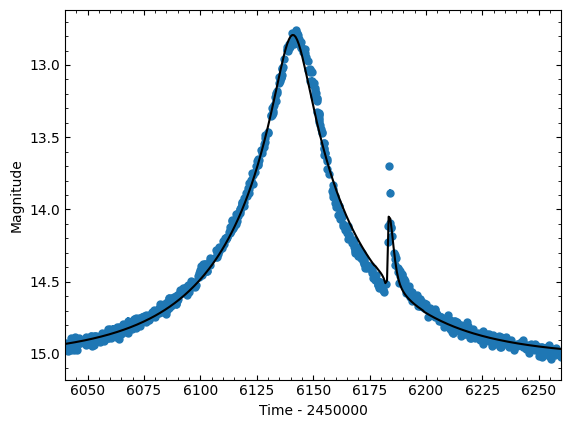

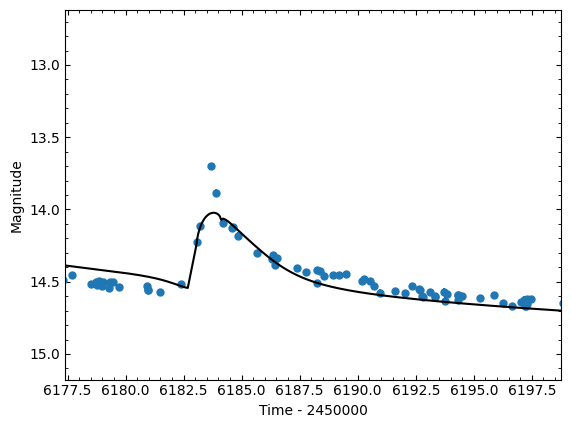

Total Runtime: 2:08:43.170213


In [68]:
# Plot the best-fit model and output the parameters
# Whole model
t_range_whole = [best_fit_model.parameters.t_0 - 5. * best_fit_model.parameters.t_E,
                 best_fit_model.parameters.t_0 + 5. * best_fit_model.parameters.t_E]

# Zoom of planet
t_range_planet = [t_min, t_max]
# Extract best fit
chi2 = [x[0] for x in fits]
fit_parameters = [x[1] for x in fits]
index_best = np.argmin(chi2)

# Setup the model and event
parameters = {}
for i, parameter in enumerate(parameters_to_fit):
    parameters[parameter] = fit_parameters[index_best][i]

final_model = mm.Model(parameters)
final_model.set_magnification_methods(magnification_methods)
final_event = mm.Event(datasets=data, model=final_model)
print(final_event.model)
print('chi2: {0}'.format(final_event.get_chi2()))

# Plot the whole light curve
final_event.plot_data(subtract_2450000=True)
final_event.plot_model(t_range=t_range_whole,
                       subtract_2450000=True, color='black', zorder=10)
plt.show()

# Plot zoom of the planet
final_event.plot_data(subtract_2450000=True)
final_event.plot_model(t_range=t_range_planet, subtract_2450000=True, color='black', zorder=10)
plt.xlim(t_min - 2450000., t_max - 2450000.)
plt.show()

end_time = datetime.now()
print('Total Runtime: {0}'.format(end_time - start_time))

In [69]:
# Update the config file with the best-fit parameters from the final_event
config_file = '/content/example_15_CENCA.cfg'
config = configparser.ConfigParser()
config.optionxform = str
config.read(config_file)

# Read config file to get original bounds and starting values
config_read = configparser.ConfigParser()
config_read.optionxform = str
config_read.read(config_file)

# Extract original min/max and starting values
original_starting = read.read_parameters_start(config_read)[1]
original_min_values, original_max_values = read.read_min_max(config_read)

# Get the best-fit parameters from final_event
best_fit_params = final_event.model.parameters.as_dict()

st_devs = {'t_0': (best_fit_params['t_0'] - 2450000.)*0.005,
            'u_0': best_fit_params['u_0']*0.3,
            't_E': best_fit_params['t_E']*0.1,
            'rho': best_fit_params['rho']*0.1,
            's': best_fit_params['s']*0.1,
            'alpha': best_fit_params['alpha']*0.1}


# Update the [EMCEE starting] section
# Handle each parameter individually
param = 't_0'
if param in parameters_to_fit:
    value = best_fit_params[param]
    config['EMCEE starting'][param] = f"gauss {value} {st_devs[param]}"


param = 'u_0'
if param in parameters_to_fit:
    value = best_fit_params[param]
    config['EMCEE starting'][param] = f"gauss {value} {st_devs[param]}"


param = 't_E'
if param in parameters_to_fit:
    value = best_fit_params[param]
    config['EMCEE starting'][param] = f"gauss {value} {st_devs[param]}"


param = 'rho'
if param in parameters_to_fit:
    value = best_fit_params[param]
    config['EMCEE starting'][param] = f"gauss {value} {st_devs[param]}"

param = 'alpha'
if param in parameters_to_fit:
    value = best_fit_params[param]
    config['EMCEE starting'][param] = f"gauss {value} {st_devs[param]}"


param = 's'
if param in parameters_to_fit:
    value = best_fit_params[param]
    config['EMCEE starting'][param] = f"gauss {value} {st_devs[param]}"


n_sigma = 3.0

# Update the [EMCEE min values] and [EMCEE max values] sections
# Handle each parameter individually
param = 'u_0'
if param in parameters_to_fit and param not in ['alpha', 'q']:
    value = best_fit_params[param]
    config['EMCEE min values'][param] = str(value - n_sigma*st_devs[param])
    config['EMCEE max values'][param] = str(value + n_sigma*st_devs[param])


param = 't_E'
if param in parameters_to_fit and param not in ['alpha', 'q']:
    value = best_fit_params[param]
    config['EMCEE min values'][param] = str(value - n_sigma*st_devs[param])
    config['EMCEE max values'][param] = str(value + n_sigma*st_devs[param])



param = 's'
if param in parameters_to_fit and param not in ['alpha', 'q']:
    value = best_fit_params[param]
    config['EMCEE min values'][param] = str(value - n_sigma*st_devs[param])
    config['EMCEE max values'][param] = str(value + n_sigma*st_devs[param])




# Write the updated config back to the file
with open(config_file, 'w') as configfile:
    config.write(configfile)

print(f"Updated {config_file} with best-fit parameters, keeping original bounds for alpha and q.")

Updated /content/example_15_CENCA.cfg with best-fit parameters, keeping original bounds for alpha and q.


In [70]:
# Read config file.
config_file = '/content/example_15_CENCA.cfg'

config = configparser.ConfigParser()
config.optionxform = str  # So that "t_E" is not changed to "t_e".
config.read(config_file)
files = read.read_files_from_config(config)
model_settings = read.read_model_settings(config)
(parameters, starting) = read.read_parameters_start(config)
fixed_parameters = read.read_fix_parameters(config)
(min_values, max_values) = read.read_min_max(config)
ln_prior.min = min_values
ln_prior.max = max_values
print(ln_prior.min)
print(ln_prior.max)

emcee_settings = read.read_emcee_settings(config)
other_settings = read.read_other(config)

# Read photometric data.
datasets = [mm.MulensData(file_name=f[0], phot_fmt=f[1]) for f in files]

{'t_0': 2456040.0, 'u_0': 0.01158213058131033, 't_E': 43.493733102323276, 'rho': 0.0, 'q': 1e-05, 's': 0.984215427336476, 'alpha': 0.0}
{'t_0': 2456260.0, 't_E': 80.77407576145752, 'rho': 0.1, 'alpha': 360.0, 'q': 0.01, 's': 1.8278286507677415, 'u_0': 0.22006048104489634}


In [73]:
import multiprocessing

# Generate starting values of parameters.
start = generate_random_parameters(parameters, starting,
                                   emcee_settings['n_walkers'], n_sigma)

# Setup Event instance that combines model and data.
par = dict(zip(parameters, start[0]))
par = {**par, **fixed_parameters}
my_model = mm.Model(par, coords=model_settings['coords'])
if 'methods' in model_settings:
    my_model.set_magnification_methods(model_settings['methods'])
if 'default_method' in model_settings:
    my_model.default_magnification_method = model_settings['default_method']
my_event = mm.Event(datasets=datasets, model=my_model)

print(start)
# Prepare sampler.
n_dim = len(parameters)
print_models = other_settings.get('print_models', False)
args = (my_event, parameters, print_models)
# --- Start of Parallelization ---
# Use the number of available CPUs to set up the worker pool
try:
    n_cpus = multiprocessing.cpu_count()
    print(f"Starting MCMC with {n_cpus} parallel processes.")
    with multiprocessing.Pool(n_cpus) as pool:
        sampler = emcee.EnsembleSampler(
            emcee_settings['n_walkers'], n_dim, ln_prob,
            args=args, pool=pool
        )
        sampler.run_mcmc(start, 500, progress=True)
except Exception as e:
    print(f"An error occurred during parallelization: {e}")
    print("Falling back to a single process MCMC run.")
    sampler = emcee.EnsembleSampler(
        emcee_settings['n_walkers'], n_dim, ln_prob,
        args=args
    )
    sampler.run_mcmc(start, 500, progress=True)

t_0
2456048.9271984277 2456233.158483659
u_0
0.01158213058131033 0.22006048104489634
t_E
43.493733102323276 80.77407576145752
rho
0.006173714739755147 0.011465470230973846
q
s
0.984215427336476 1.8278286507677415
alpha
119.74098448839598 222.37611404987828
[[2456129.8751353477, 0.17594885098004404, 70.22466870196847, 0.008710877131821155, 0.0003238424385426117, 1.3150495706156051, 154.62014501474903], [2456172.9067994948, 0.1084232130900671, 67.64210875218166, 0.008267408218040556, 1.628708950857566e-05, 1.3063272218484139, 167.12481305764237], [2456196.930421038, 0.11010957887474711, 61.66571510743637, 0.009851063145735287, 0.00020725348876944063, 1.1786089689758847, 169.1850825836008], [2456121.388329207, 0.1889190938889297, 68.645973085921, 0.007979358622688174, 0.00012761100964887552, 1.32641184067101, 197.2110889780731], [2456177.1288924054, 0.07063193309098766, 69.45349089362082, 0.007921023705151322, 0.0002018501829012025, 1.0076505720612843, 151.8058752235307], [2456163.6571045

100%|██████████| 500/500 [48:11<00:00,  5.78s/it]


In [74]:
# Parse results.
burn = 0
samples = sampler.chain[:, burn:, :].reshape((-1, n_dim))
r_16 = np.percentile(samples, 16, axis=0)
r_50 = np.percentile(samples, 50, axis=0)
r_84 = np.percentile(samples, 84, axis=0)
print("Fitted parameters:")
for i in range(n_dim):
    if parameters[i] == 'q':
        fmt = "{:} {:.7f} +{:.7f} -{:.7f}"
    else:
        fmt = "{:} {:.5f} +{:.5f} -{:.5f}"
    print(fmt.format(parameters[i], r_50[i], r_84[i]-r_50[i], r_50[i]-r_16[i]))

# We extract best model parameters and chi2 from the chain:
prob = sampler.lnprobability[:, burn:].reshape((-1))
best_index = np.argmax(prob)
best_chi2 = prob[best_index] / -0.5
best = samples[best_index, :]
print("\nSmallest chi2 model:")
print(*[repr(b) if isinstance(b, float) else b.value for b in best])
print(best_chi2)
for (parameter, best_) in zip(parameters, best):
    setattr(my_event.model.parameters, parameter, best_)

my_event.fit_fluxes()

Fitted parameters:
t_0 2456141.31416 +0.27551 -0.19796
u_0 0.11175 +0.00955 -0.03015
t_E 63.74826 +16.25281 -1.77161
rho 0.00851 +0.00053 -0.00157
q 0.0016864 +0.0029781 -0.0009687
s 1.39098 +0.06952 -0.08921
alpha 171.44972 +0.95964 -27.85871

Smallest chi2 model:
np.float64(2456141.096232326) np.float64(0.10840476343130073) np.float64(64.45244889940382) np.float64(0.009302062403195477) np.float64(0.0005239906255411536) np.float64(1.389937524015541) np.float64(171.82916310770807)
4434.418307055581


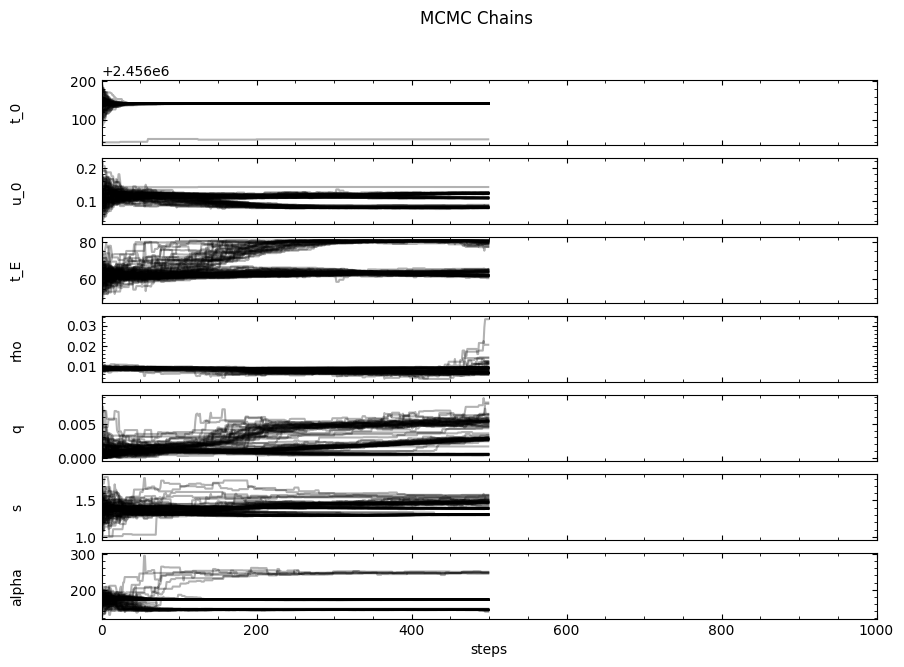

In [75]:
# Plotting the chains for each parameter
fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
for i in range(n_dim):
    ax = axes[i]
    ax.plot(sampler.get_chain()[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, emcee_settings['n_steps'])
    ax.set_ylabel(parameters[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("steps")
plt.suptitle('MCMC Chains')
plt.show()

In [76]:
def reinitialize_walkers(sampler, n_walkers, n_dim, best_index, samples):
    """
    Reinitializes the MCMC walkers from the best-fit position found in a
    previous run.

    Args:
        sampler (emcee.EnsembleSampler): The completed MCMC sampler object.
        n_walkers (int): The number of walkers in the ensemble.
        n_dim (int): The number of parameters being fitted.
        best_index (int): The index of the sample with the highest probability.
        samples (numpy.ndarray): The flattened MCMC chain.

    Returns:
        numpy.ndarray: A new starting position for the MCMC run.
    """
    # Get the best-fit parameter vector
    best_fit = samples[best_index, :]

    # Create new starting positions by adding a small jitter to the best fit
    new_start = [best_fit + 1e-4 * np.random.randn(n_dim) for i in range(n_walkers)]

    # You can also use the last position of the original walkers as a starting point.
    # The last position of the original walkers might be useful to try if you
    # suspect the best_fit is a fluke.
    # last_pos = sampler.chain[:, -1, :]

    return new_start

# Assume the previous MCMC run has already been completed, and you have
# sampler, n_walkers, n_dim, burn, samples, and best_index defined.

# Extract the best-fit parameters from the first, non-converged run
prob = sampler.lnprobability[:, burn:].reshape((-1))
best_index = np.argmax(prob)
best_fit = samples[best_index, :]

print("\nBest fit parameters from initial run:")
print(best_fit)

# Re-initialize the walkers for a new run
new_start = reinitialize_walkers(
    sampler=sampler,
    n_walkers=emcee_settings['n_walkers'],
    n_dim=n_dim,
    best_index=best_index,
    samples=samples
)

# Create a new sampler object (or reset the existing one)
# --- Start of Parallelization for the second MCMC run ---
try:
    n_cpus = multiprocessing.cpu_count()
    print(f"Starting second MCMC with {n_cpus} parallel processes.")
    with multiprocessing.Pool(n_cpus) as pool:
        sampler2 = emcee.EnsembleSampler(
            emcee_settings['n_walkers'], n_dim, ln_prob,
            args=args, pool=pool
        )
        sampler2.run_mcmc(new_start, 2500, progress=True)
except Exception as e:
    print(f"An error occurred during parallelization for the second run: {e}")
    print("Falling back to a single process MCMC run for the second run.")
    sampler2 = emcee.EnsembleSampler(
        emcee_settings['n_walkers'], n_dim, ln_prob,
        args=args
    )
    sampler2.run_mcmc(new_start, 2500, progress=True)
# --- End of Parallelization for the second MCMC run ---


# Parse and analyze the results of the second run
burn2 = 500
samples2 = sampler2.chain[:, burn2:, :].reshape((-1, n_dim))

print("\nFitted parameters from second run:")
r_16 = np.percentile(samples2, 16, axis=0)
r_50 = np.percentile(samples2, 50, axis=0)
r_84 = np.percentile(samples2, 84, axis=0)

for i in range(n_dim):
    if parameters[i] == 'q':
        fmt = "{:} {:.7f} +{:.7f} -{:.7f}"
    else:
        fmt = "{:} {:.5f} +{:.5f} -{:.5f}"
    print(fmt.format(parameters[i], r_50[i], r_84[i]-r_50[i], r_50[i]-r_16[i]))


Best fit parameters from initial run:
[2.45614110e+06 1.08404763e-01 6.44524489e+01 9.30206240e-03
 5.23990626e-04 1.38993752e+00 1.71829163e+02]
Starting second MCMC with 2 parallel processes.


100%|██████████| 2500/2500 [6:55:52<00:00,  9.98s/it]


Fitted parameters from second run:
t_0 2456141.15182 +0.02934 -0.02820
u_0 0.10594 +0.00239 -0.00224
t_E 66.04965 +1.08627 -1.10240
rho 0.01514 +0.00064 -0.00060
q 0.0008368 +0.0000485 -0.0000454
s 1.37921 +0.00732 -0.00695
alpha 172.37552 +0.06184 -0.06337


In [77]:
!pip install Corner

import corner

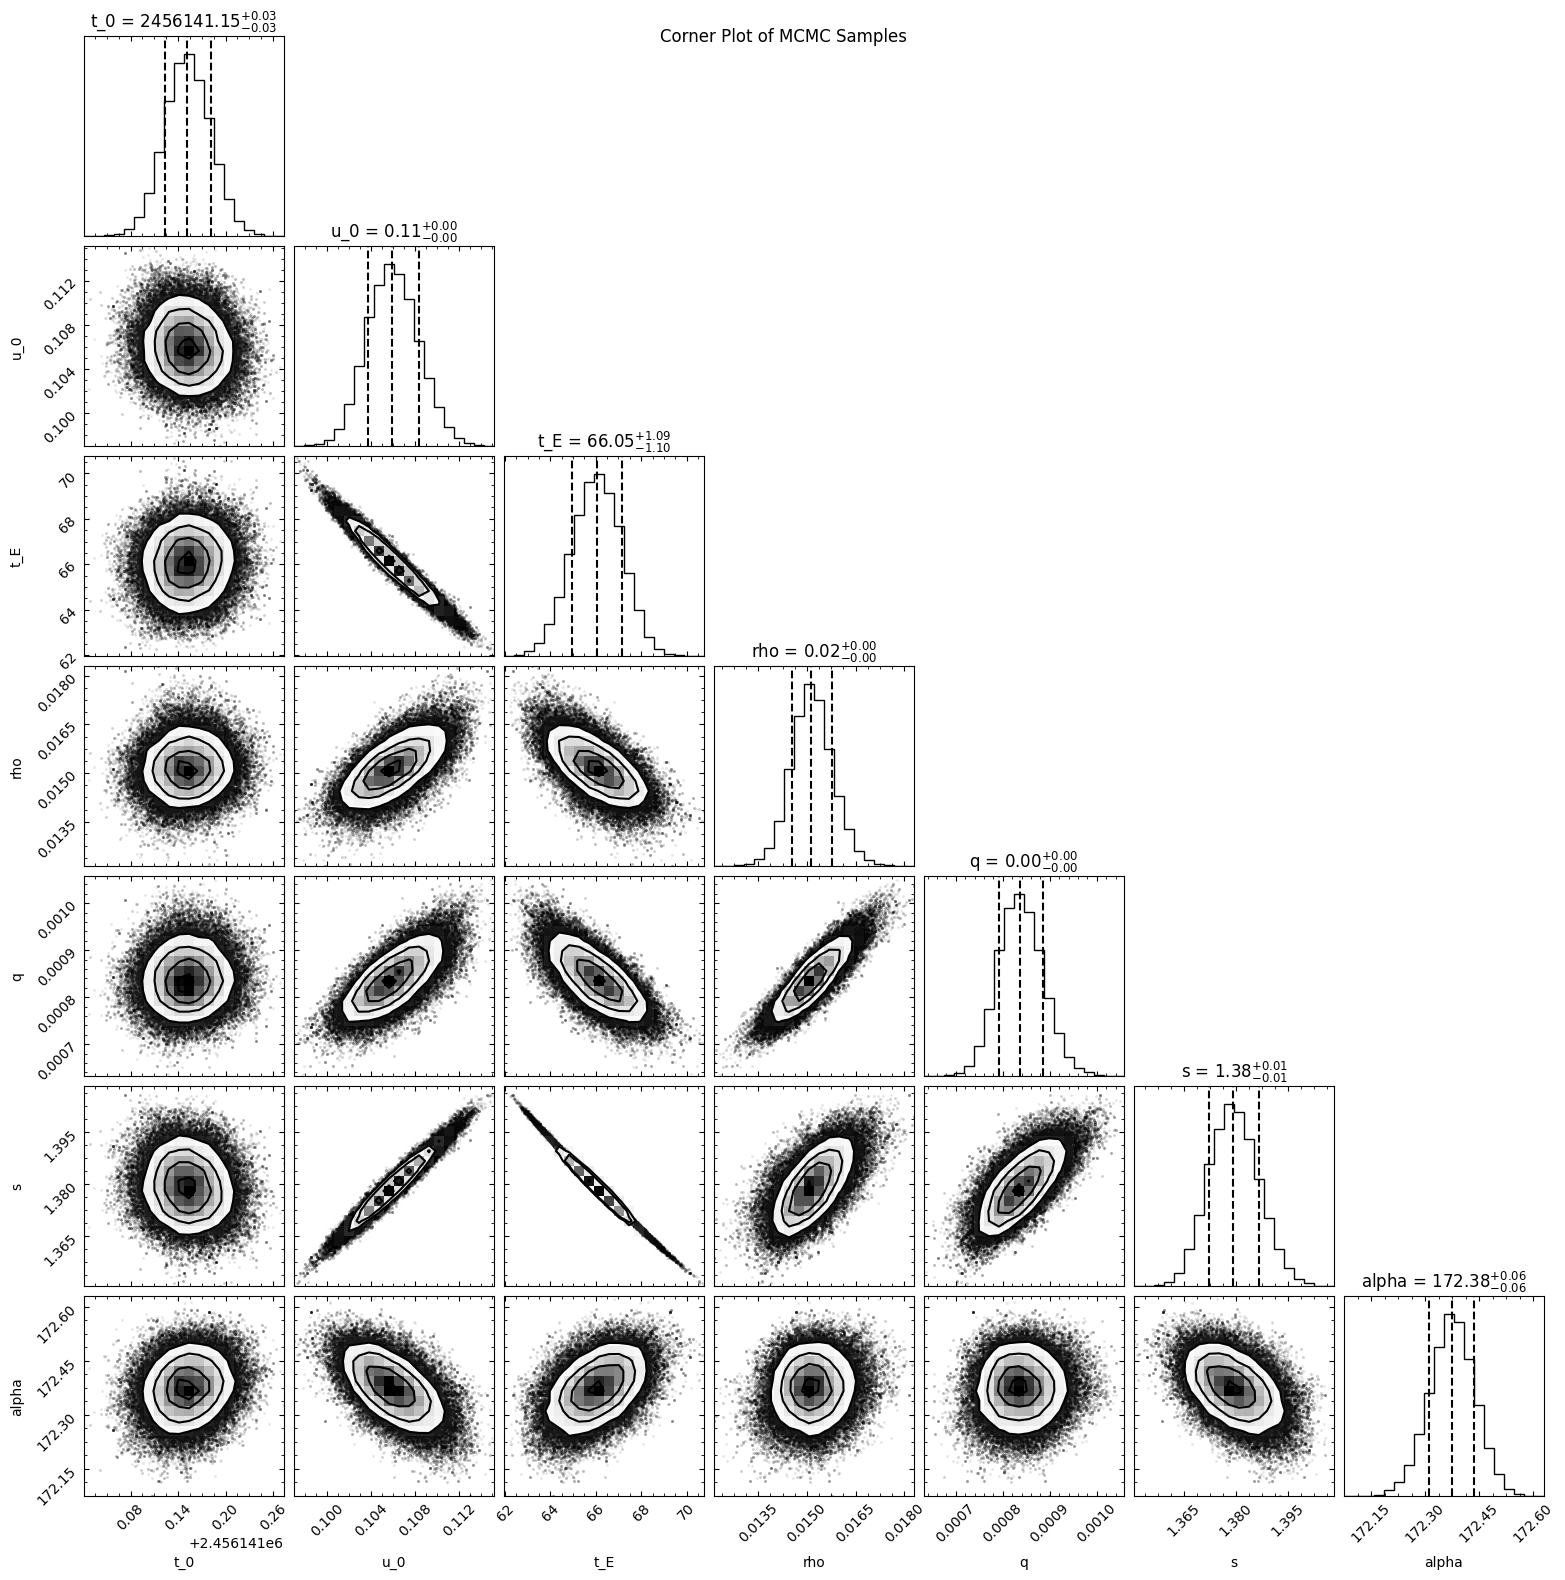

In [78]:
# Plotting the corner plot.
fig = corner.corner(samples2, labels=parameters,
                    quantiles=[0.16, 0.5, 0.84], show_titles=True,
                    title_kwargs={"fontsize": 12})
plt.suptitle('Corner Plot of MCMC Samples')
plt.show()

In [1]:
# Plot results from the second MCMC run.
# We extract best model parameters and chi2 from the chain of the second run:
prob2 = sampler2.lnprobability[:, burn2:].reshape((-1))
best_index2 = np.argmax(prob2)
best2 = samples2[best_index2, :]
best_chi2_second_run = prob2[best_index2] / -0.5

print("\nSmallest chi2 model from second run:")
print(*[repr(b) if isinstance(b, float) else b.value for b in best2])
print(best_chi2_second_run)

# Setup the model and event with parameters from the best fit of the second run
parameters_second_run = {}
for i, parameter in enumerate(parameters):
    parameters_second_run[parameter] = best2[i]

final_model_second_run = mm.Model(parameters_second_run)
final_model_second_run.set_magnification_methods(model_settings['methods'])
final_event_second_run = mm.Event(datasets=datasets, model=final_model_second_run)

# Fit fluxes for the best model from the second run
final_event_second_run.fit_fluxes()

# Plot the whole light curve with the best model from the second run
#my_event.plot_data(subtract_2450000=True) # Assuming 'my_event' still holds the data
final_event_second_run.plot_data(subtract_2450000=True)
final_event_second_run.plot_model(
    subtract_2450000=True,
    t_start=other_settings['plot_time'][0] + 2450000,
    t_stop=other_settings['plot_time'][1] + 2450000)
plt.xlim(*other_settings['plot_time'])
plt.show()

NameError: name 'sampler2' is not defined

In [80]:
# Find the difference between the PSPL and the binary model chi2 values

# Chi2 of the PSPL model is available from the initial fit (cell IilhPAsHdd_w)
# It was printed as "Chi2 of the point lens model: [value]"
# Let's assume we can access it or re-calculate it if needed.
# For now, let's assume the variable `point_lens_event` from cell IilhPAsHdd_w is still available.
# If not, we would need to re-execute that part or store the chi2 in a variable.
pspl_chi2 = chi2_all_data

# Chi2 of the best-fit binary model from the second MCMC run is available
# It was printed in cell 2pLB3M91967P as "Smallest chi2 model: [value]"
# Let's assume the variable `best_chi2` from cell 2pLB3M91967P is still available.
# If not, we would need to re-execute that part or store the chi2 in a variable.
binary_chi2 = best_chi2

# Calculate the difference in chi2
chi2_difference = pspl_chi2 - binary_chi2

print(f"Chi2 difference (PSPL - Binary): {chi2_difference/len(data_all.time)}")

# Check if the difference is over 60 and print the result
if (chi2_difference/len(data_all.time)) > 60:
    print("The system has passed the detection threshold.")
else:
    print("The system has not passed the detection threshold, or the fit has failed.")

Chi2 difference (PSPL - Binary): 2951.8430671801425
The system has passed the detection threshold.


We to test uniform values -> u_0 = [0.1, 0.5, 0.9, 1.3]